In [1]:
import re
import os
import pathlib
import json
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()


# Experiment constants
exp_name = "02_http_constant_throughput"
file_prefix = "exp-02"

In [2]:
"""Load and prepare the dataset

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

df = pd.read_feather(data_dir / "resource_results.feather")
df = df.astype({
    "experiment": "category",
    "mesh": "category",
    "requested_qps": "category",
    "cpu": np.float64,
    "mem": np.float64,
})
df = df[df["experiment"] == exp_name]
df.head()

,experiment,mesh,requested_qps,pod,container,cpu,mem,date,delta
3301,02_http_constant_throughput,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,0.890197,183329.848074,2022-06-26 14:47:26,0 days 00:00:00
3302,02_http_constant_throughput,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,0.863798,177893.136284,2022-06-26 14:47:29,0 days 00:00:03
3303,02_http_constant_throughput,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,0.848032,120340.086656,2022-06-26 14:47:32,0 days 00:00:06
3304,02_http_constant_throughput,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,0.821574,116585.442912,2022-06-26 14:47:35,0 days 00:00:09
3305,02_http_constant_throughput,Baseline,1,target-fortio-746f85d498-tmrfm,fortio,0.677814,173817.135877,2022-06-26 14:47:38,0 days 00:00:12


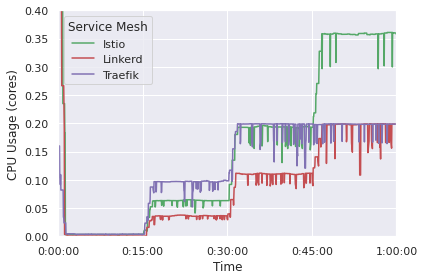

In [23]:
"""
PLOT:Line CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-cpu-utilization.pdf"

fig, ax = plt.subplots()


data = df[df["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data["delta"] = data.groupby(["experiment", "mesh"])["date"].transform(lambda x: x - x.min())

# Adds time delta per experiment
data["mem"] /= 1000

sns.lineplot(data=data, x="delta", y="cpu", hue="mesh", ax=ax)

# Labels
ax.set_ylabel("CPU Usage (cores)")
ax.set_xlabel("Time")

# Custom Legend Fixing
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l in ["Istio", "Linkerd", "Traefik"]:
        lablout.append(l)
        handout.append(h)
ax.legend(handles=handout, labels=lablout, title="Service Mesh")

ax.set_xlim(0, 60 * 60 * 10e8)
ax.set_ylim(0, 0.4)

def timeTicks(x, pos):
    seconds = x / 10**9 # convert nanoseconds to seconds
    # create datetime object because its string representation is alright
    d = datetime.timedelta(seconds=seconds)
    return str(d)

formatter = ticker.FuncFormatter(timeTicks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))


# ax.set_xscale("log")

fig.tight_layout()
fig.savefig(plot_dir / file_name)


Text(0.5, 0, 'Service Mesh')

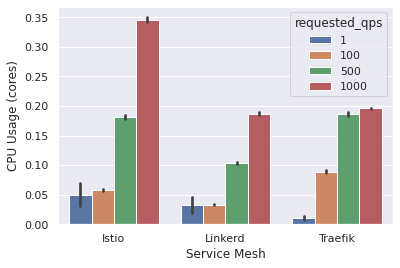

In [34]:
data = df[df["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data["delta"] = data.groupby(["experiment", "mesh"])["date"].transform(lambda x: x - x.min())


fig, ax = plt.subplots()
sns.barplot(data=data, x="mesh", y="cpu", hue="requested_qps", order=["Istio", "Linkerd", "Traefik"], hue_order=["1", "100", "500", "1000"], ax=ax)
ax.legend(title="QPS")

# Labels
ax.set_ylabel("CPU Usage (cores)")
ax.set_xlabel("Service Mesh")

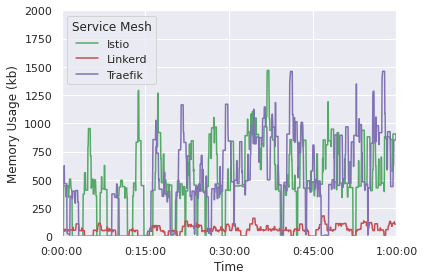

In [26]:

"""
PLOT:Line CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-memory-utilization.pdf"

fig, ax = plt.subplots()


data = df[df["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]

# Adds time delta per experiment
# data["delta"] = data.sort_values(["mesh", "date"]).groupby("mesh")["date"].transform(lambda x: x - x.min())
data["delta"] = data.groupby(["experiment", "mesh"])["date"].transform(lambda x: x - x.min())
data["mem"] /= 1000

sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)

# Labels
ax.set_ylabel("Memory Usage (kb)")
ax.set_xlabel("Time")

# Custom Legend Fixing
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l in ["Istio", "Linkerd", "Traefik"]:
        lablout.append(l)
        handout.append(h)
ax.legend(handles=handout, labels=lablout, title="Service Mesh")

ax.set_xlim(0, 60 * 60 * 10e8)
ax.set_ylim(0, 2000)

def timeTicks(x, pos):
    seconds = x / 10**9 # convert nanoseconds to seconds
    # create datetime object because its string representation is alright
    d = datetime.timedelta(seconds=seconds)
    return str(d)

formatter = ticker.FuncFormatter(timeTicks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))


# ax.set_xscale("log")

# Second plot with cumulative density
# ax2 = ax.twinx()
# ax2.set_alpha(0.5)
# ax2.grid(False)
# sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)
# # ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)
